In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import defaultdict
import panns_inference
from panns_inference import AudioTagging, SoundEventDetection, labels

import sys
sys.path.append('../ASC_AED_JoinTask/Datasets/')
sys.path.append('../ASC_AED_JoinTask/models/')
import ASC_datasets
import audio_utils as au

TUT_AUD_DIR = ASC_datasets.TUT_AUD_DIR
SAMPLE_RATE = 32000

In [2]:
csv = 'tut_preds/Cnn9_64mel_tut_ablatedScenePreds.csv'
df = pd.read_csv(csv)
scenes = df.scene_preds.unique()

In [4]:
at = AudioTagging(checkpoint_path='../ASC_AED_JoinTask/models/Cnn14_mAP=0.431.pth', device='cuda')

def get_event_list(clipwise_output):
    # With the slicing, we are reversing the sorted index to get the descending order of event probs.
    sorted_indexes = np.argsort(clipwise_output)[::-1]
    event_list = []

    # Creating a list of events with more than 0.05 prob
    for i in range(0, len(sorted_indexes)):
        event_prob = clipwise_output[sorted_indexes[i]]
        if event_prob > 0.1:
            event_list.append(np.array(labels)[sorted_indexes[i]])
    
    return event_list


def get_panns_events_list(audio):
    
    audio = audio[None, :]
    clipwise_op, embedding = at.inference(audio)

    event_list = get_event_list(clipwise_op[0])
    return event_list

Checkpoint path: ../ASC_AED_JoinTask/models/Cnn14_mAP=0.431.pth
GPU number: 4


In [23]:
# Loop for predicting audio tags for the original audio
audio_tags_org = []

for i, row in df.iterrows():
    fname = os.path.join(TUT_AUD_DIR, row['files'])
    audio = au.load_audio_from_file(fname, sample_rate=SAMPLE_RATE)
    audio_tags_org.append(get_panns_events_list(audio))

In [27]:
df['audio_tags_org'] = audio_tags_org

In [3]:
audioset_ontology_df = pd.read_json('audioset_ontology.json')

def get_event_ids(event_id):
    idx = audioset_ontology_df[audioset_ontology_df['child_ids'].apply(lambda x: event_id in x)]
    if len(idx) > 0:
        return idx['id'].iloc[0]
    else:
        return 'None'
    
def get_immediate_parent_class_label(event_label):
    event_row = audioset_ontology_df.loc[audioset_ontology_df['name']==event_label]
    event_id = event_row['id'].to_string(index=False)
    parent_event_id = get_event_ids(event_id)
    parent_class_label = audioset_ontology_df[audioset_ontology_df['id']==parent_event_id]['name'].to_string(index=False)
    if parent_event_id == 'None':
        return 'None'
    else:
        return parent_class_label

def get_parent_class_label(event_label):
    event_row = audioset_ontology_df.loc[audioset_ontology_df['name']==event_label]
    event_id = event_row['id'].to_string(index=False)
    parent_event_id = get_event_ids(event_id)
    while get_event_ids(parent_event_id) != 'None':
        parent_event_id = get_event_ids(parent_event_id)
    parent_class_label = audioset_ontology_df[audioset_ontology_df['id']==parent_event_id]['name'].to_string(index=False)
    if parent_event_id == 'None':
        return 'None'
    else:
        return parent_class_label


In [4]:
import ast

csv = 'tut_preds/Cnn9_64mel_tut_ablatedScenePreds_withOrgTags.csv'
df = pd.read_csv(csv)
scenes = df['labels'].unique()
df['audio_tags_org'] = df['audio_tags_org'].apply(lambda x: ast.literal_eval(x))

In [5]:
# Counting all the tags in the original audio
all_tags = set()

rearranged_filtered_tags = ['Outside, urban or manmade', 'Inside, public space', 'Recording', 'Animal', 'Natural sounds',
 'Human sounds', 'Human locomotion', 'Clip-clop', 'Rail transport', 'Vehicle', 'Music', 'Rumble', 'Clickety-clack']

for i, row in df.iterrows():
    tags = row['audio_tags_org']
    for tag in tags:
        all_tags.add(tag)

In [6]:
# PANNs unique audio tags and counts for each scene
scene_tag_counts = defaultdict(dict)
all_tags = list(all_tags)

for scene in scenes:
    for tag in all_tags:
        scene_tag_counts[scene][tag] = 0


# Counting the tags for each scene
for i, row in df.iterrows():
    tags = row['audio_tags_org']
    for tag in tags:
        scene_tag_counts[row['labels']][tag] += 1


# Initiliasing the rearranged filtered tags
scene_filtered_tags_counts = defaultdict(dict)
for scene in scenes:
    for tag in rearranged_filtered_tags:
        scene_filtered_tags_counts[scene][tag] = 0

In [96]:
pd.DataFrame(scene_tag_counts)['airport'].sort_values(ascending=False)

Speech                       252
Vehicle                      244
Train                         74
Outside, urban or manmade     67
Music                         63
                            ... 
Inside, small room             0
Civil defense siren            0
Duck                           0
Slam                           0
Crack                          0
Name: airport, Length: 162, dtype: int64

In [7]:
# Creating a dataframe
scene_tag_counts_df = pd.DataFrame.from_dict(scene_tag_counts)

# Actually counting the filtered tags based on a threshold
for scene in scenes:
    # Need commenting after we have decided upon an approach
    total_files = df['labels'].value_counts()[scene]
    #total_tags_per_scene = scene_tag_counts_df[scene].sum()

    for index in scene_tag_counts_df.index:
        #scene_tag_counts_df[scene][index] = (scene_tag_counts_df[scene][index])/total
        tag = index
        if (scene_tag_counts_df[scene][index])/total_files > 0.1:
            if index in rearranged_filtered_tags:
                scene_filtered_tags_counts[scene][index] += (scene_tag_counts_df[scene][index])
            else:
                while tag not in rearranged_filtered_tags:
                    tag = get_immediate_parent_class_label(tag)
                scene_filtered_tags_counts[scene][tag] += (scene_tag_counts_df[scene][index])


In [8]:
pd.DataFrame(scene_filtered_tags_counts)['airport'].sort_values(ascending=False)

Vehicle                      314
Human sounds                 302
Rail transport               220
Outside, urban or manmade     67
Music                         63
Human locomotion              30
Inside, public space           0
Wind                           0
Recording                      0
Ocean                          0
Animal                         0
Clip-clop                      0
Aircraft                       0
Rumble                         0
Clickety-clack                 0
Name: airport, dtype: int64

In [17]:
# Normalizing the filtered tags
scene_filtered_tags_counts_df = pd.DataFrame.from_dict(scene_filtered_tags_counts)

for scene in scenes:
    total = scene_filtered_tags_counts_df[scene].sum()
    #total = df['labels'].value_counts()[scene]
    for index in scene_filtered_tags_counts_df.index:
        scene_filtered_tags_counts_df[scene][index] = (scene_filtered_tags_counts_df[scene][index])/total

/tmp/ipykernel_444561/2578130740.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.06726907630522089' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  scene_filtered_tags_counts_df[scene][index] = (scene_filtered_tags_counts_df[scene][index])/total
/tmp/ipykernel_444561/2578130740.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scene_filtered_tags_counts_df[scene][index] = (scene_filtered_tags_counts_df[scene][index])/total
/tmp/ipykernel_444561/2578130740.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.057624113475177305' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

In [18]:
scene_filtered_tags_counts_df.columns
rearranged_column_list = ['metro', 'metro_station', 'tram', 'bus',
                          'street_traffic', 'street_pedestrian', 'public_square', 'park',
                          'airport', 'shopping_mall']

scene_filtered_tags_counts_df = scene_filtered_tags_counts_df[rearranged_column_list]

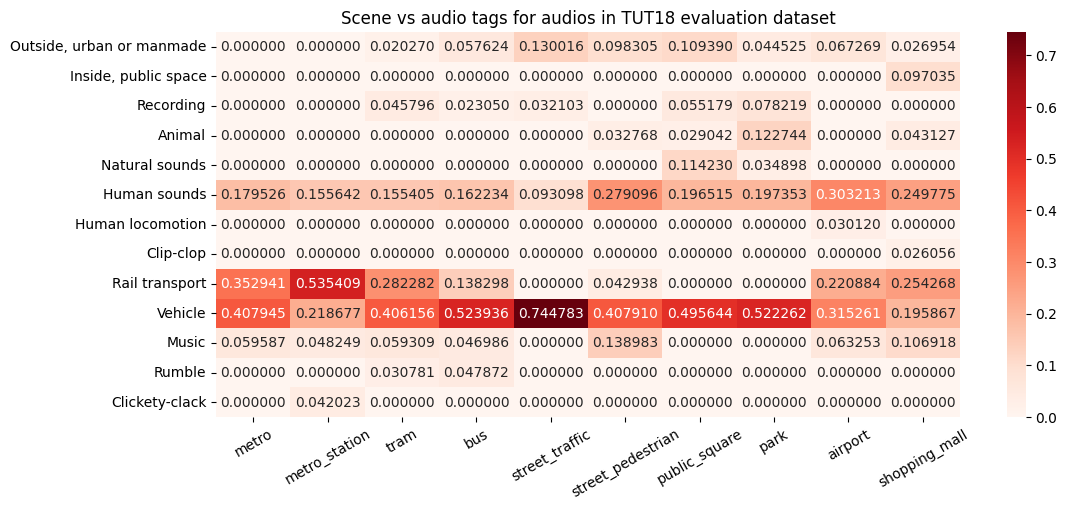

In [19]:
plt.figure(figsize=(12,5))
plt.title('Scene vs audio tags for audios in TUT18 evaluation dataset')
sns.heatmap(scene_filtered_tags_counts_df, fmt='f', annot=True, cmap='Reds')
plt.xticks(rotation=30)
plt.show()

In [20]:
# Now we want to understand the model behavior
# We will use the audio tags from the original dataset to understand the patterns that the model might have observed
correct_scene_tags_count = defaultdict(dict)
incorrect_scene_tags_count = defaultdict(dict)
correct_scene_filtered_tags_count = defaultdict(dict)
incorrect_scene_filtered_tags_count = defaultdict(dict)
# Initialiing the dict
for scene in scenes:
    for tag in all_tags:
        correct_scene_tags_count[scene][tag] = 0
        incorrect_scene_tags_count[scene][tag] = 0
    for tag in rearranged_filtered_tags:
        correct_scene_filtered_tags_count[scene][tag] = 0
        incorrect_scene_filtered_tags_count[scene][tag] = 0
# Counting
for i, row in df.iterrows():
    tags = row['audio_tags_org']
    # We can change the following condition in order to see the behavior of the model for a specific type of predictions (correctly predicted or mispredicted)
    # if this condition is commented, that means we are observing the behavior of all the PREDICTIONS
    #if row['labels'] != row['scene_preds']:
    for tag in tags:
        if row['labels'] == row['scene_preds']:
            correct_scene_tags_count[row['scene_preds']][tag] += 1
        elif row['labels'] != row['scene_preds']:
            incorrect_scene_tags_count[row['scene_preds']][tag] += 1

# Counting the filtered tags
for scene in scenes:
    # As was the case earlier, we are only considering audio tags having a threshold of 14%
    total_correct = len(df[df['scene_preds']==scene])
    
    for tag in all_tags:
        index = tag
        if (correct_scene_tags_count[scene][tag])/total_correct > 0.14:
            # We then merge the tag count to the filtered tags
            if tag in rearranged_filtered_tags:
                correct_scene_filtered_tags_count[scene][tag] += (correct_scene_tags_count[scene][tag])
            else:
                while index not in rearranged_filtered_tags:
                    index = get_immediate_parent_class_label(index)
                correct_scene_filtered_tags_count[scene][index] += (correct_scene_tags_count[scene][tag])


for scene in scenes:
    # As was the case earlier, we are only considering audio tags having a threshold of 14%
    total_incorrect = len(df[df['scene_preds']!=scene])
    
    for tag in all_tags:
        index = tag
        #print(index)
        if (incorrect_scene_tags_count[scene][tag])/total_incorrect > 0.05:
            # We then merge the tag count to the filtered tags
            if tag in rearranged_filtered_tags:
                incorrect_scene_filtered_tags_count[scene][tag] += (incorrect_scene_tags_count[scene][tag])
            else:
                while index not in rearranged_filtered_tags:
                    index = get_immediate_parent_class_label(index)
                incorrect_scene_filtered_tags_count[scene][index] += (incorrect_scene_tags_count[scene][tag])


In [21]:
# Normalizing the filtered tags
correct_scene_filtered_tags_count_df = pd.DataFrame.from_dict(correct_scene_filtered_tags_count)
incorrect_scene_filtered_tags_count_df = pd.DataFrame.from_dict(incorrect_scene_filtered_tags_count)

for scene in scenes:
    # Normalizing wrt the total number of audio tags predicted for that scene
    total_correct = correct_scene_filtered_tags_count_df[scene].sum()
    total_incorrect = incorrect_scene_filtered_tags_count_df[scene].sum()
    #total = df['labels'].value_counts()[scene]
    
    for index in incorrect_scene_filtered_tags_count_df.index:
        correct_scene_filtered_tags_count_df[scene][index] = (correct_scene_filtered_tags_count_df[scene][index])/total_correct
        incorrect_scene_filtered_tags_count_df[scene][index] = (incorrect_scene_filtered_tags_count_df[scene][index])/total_incorrect


/tmp/ipykernel_444561/1332685203.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.1391304347826087' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  correct_scene_filtered_tags_count_df[scene][index] = (correct_scene_filtered_tags_count_df[scene][index])/total_correct
/tmp/ipykernel_444561/1332685203.py:13: RuntimeWarning: invalid value encountered in scalar divide
  incorrect_scene_filtered_tags_count_df[scene][index] = (incorrect_scene_filtered_tags_count_df[scene][index])/total_incorrect
/tmp/ipykernel_444561/1332685203.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_scene_filtered_tags_count_df[scene][index] = (correct_scene_filtered_tags_count_df[scene][index])/total_c

In [22]:
incorrect_scene_filtered_tags_count_df.fillna(0, inplace=True)

#print(correct_scene_filtered_tags_count_df.columns)
correct_scene_filtered_tags_count_df = correct_scene_filtered_tags_count_df[rearranged_column_list]
incorrect_scene_filtered_tags_count_df = incorrect_scene_filtered_tags_count_df[rearranged_column_list]

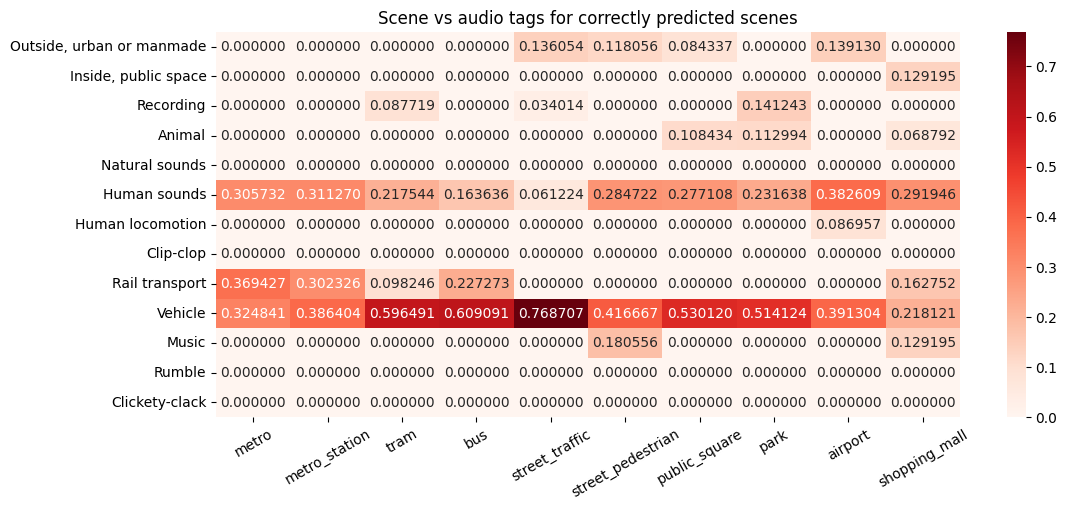

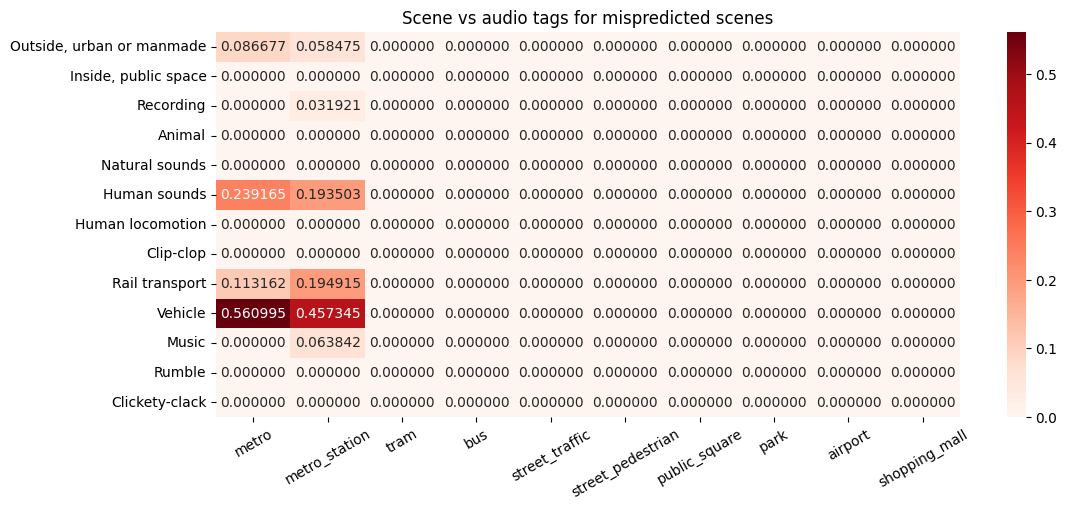

In [23]:
plt.figure(figsize=(12,5))
plt.title('Scene vs audio tags for correctly predicted scenes')
sns.heatmap(correct_scene_filtered_tags_count_df, fmt='f', annot=True, cmap='Reds')
plt.xticks(rotation=30)
plt.show()

plt.figure(figsize=(12,5))
plt.title('Scene vs audio tags for mispredicted scenes')
sns.heatmap(incorrect_scene_filtered_tags_count_df, fmt='f', annot=True, cmap='Reds')
plt.xticks(rotation=30)
plt.show()

In [43]:
df[df['labels']!=df['scene_preds']]['scene_preds'].value_counts(), len(df[df['labels']!=df['scene_preds']]['scene_preds']), len(df)

(scene_preds
 metro_station        846
 metro                367
 tram                  85
 bus                   68
 shopping_mall         65
 street_pedestrian     40
 park                  20
 street_traffic        12
 airport                9
 public_square          8
 Name: count, dtype: int64,
 1520,
 2518)

<Axes: >

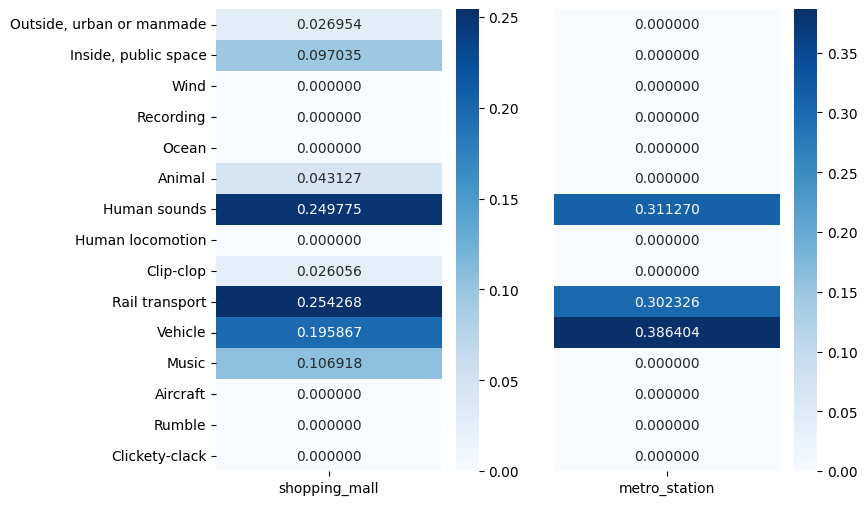

In [48]:
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
sns.heatmap(scene_filtered_tags_counts_df[['shopping_mall']], fmt='f', annot=True, cmap='Blues')
plt.subplot(1, 2, 2)
sns.heatmap(correct_scene_filtered_tags_count_df[['metro_station']], fmt='f', annot=True, cmap='Blues', yticklabels=False)

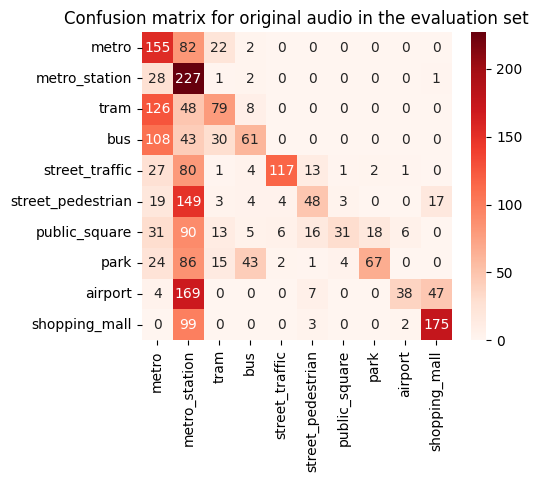

In [34]:
from sklearn.metrics import confusion_matrix
labels = ['bus', 'metro', 'tram', 'metro_station', 'street_traffic', 'street_pedestrian', 'public_square', 'park', 'airport', 'shopping_mall']
cm = confusion_matrix(df['labels'], df['scene_preds'], labels=rearranged_column_list)

plt.figure(figsize=(5,4))
plt.title('Confusion matrix for original audio in the evaluation set')
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=rearranged_column_list, yticklabels=rearranged_column_list)
#plt.xticks(rotation=75)
plt.show()